In [1]:
import os, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from typing import Tuple
warnings.simplefilter('ignore', FutureWarning)

In [2]:
pth_data = os.path.join('..', 'data', 'modeling', 'predict')
pth_out = os.path.join('..', 'figures')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_data, 'TCGA.h5ad'))
adata

AnnData object with n_obs × n_vars = 10496 × 856
    obs: '_PATIENT', 'cancer type abbreviation', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type', 'histological_grade', 'initial_pathologic_dx_year', 'menopause_status', 'birth_days_to', 'vital_status', 'tumor_status', 'last_contact_days_to', 'death_days_to', 'cause_of_death', 'new_tumor_event_type', 'new_tumor_event_site', 'new_tumor_event_site_other', 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course', 'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction', 'source', 'latent_z'

In [4]:
# survival analysis wrapper function
def fit_survival(df: pd.DataFrame,
                 cancer_type: str,
                 survival_type: str,
                 stratify_by: str,
                 t_max: float | None = None,
                 q_low: float = .33,
                 q_high: float = .66,
                 **kwargs
                 ) -> Tuple[plt.Axes, float] | None:

    # select cancer type
    df = df.loc[df['cancer type abbreviation'] == cancer_type].copy()

    # deduplicate patients
    survival_type_time = survival_type + '.time'
    agg_dict = {survival_type      : 'first',
                survival_type_time : 'first',
                stratify_by        : 'mean'}
    cols = list(agg_dict.keys())
    df[cols] = df[cols].astype(float)
    df = df.groupby('_PATIENT').agg(agg_dict).dropna(subset = cols)
    df[survival_type_time] /= 365.

    if not df.empty:
        # stratify patients
        df_low = df.loc[df[stratify_by] < df[stratify_by].quantile(q_low)]
        df_high = df.loc[df[stratify_by] > df[stratify_by].quantile(q_high)]

        if not df_low.empty and not df_high.empty:
            # plot survival
            _, ax = plt.subplots(1, 1, **kwargs)
            kmf = KaplanMeierFitter()
            if t_max: timeline = np.arange(0, t_max + 1e-3, 7/365)
            else: timeline = None
            for label, _df_ in (('Low', df_low), ('High', df_high)):
                kmf.fit(_df_[survival_type_time], _df_[survival_type],
                        timeline = timeline, label = label)
                ax = kmf.plot_survival_function(ax = ax)

            # significance
            res = logrank_test(df_low[survival_type_time],
                               df_high[survival_type_time],
                               df_low[survival_type],
                               df_high[survival_type])
            return ax, res.p_value

ACC PFI 0.014387709580765263


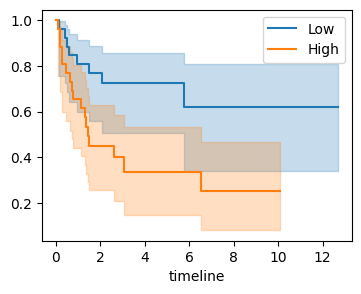

BRCA OS 0.012130872901873936


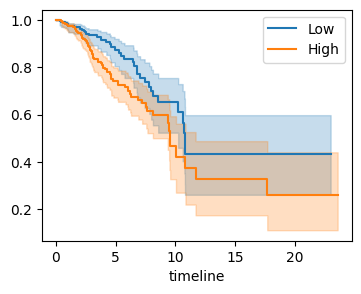

ESCA OS 0.03713634512454747


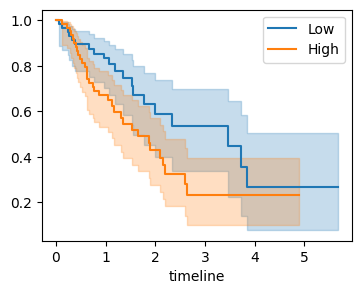

ESCA DSS 0.008680065541594317


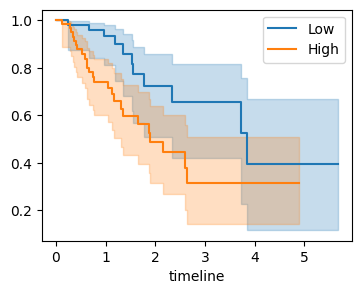

GBM PFI 0.021693431866153343


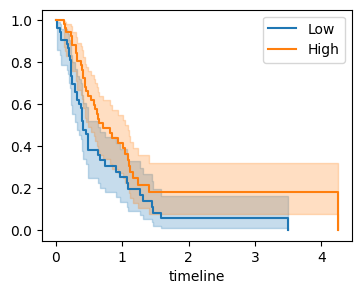

KIRC OS 0.0013137217538707088


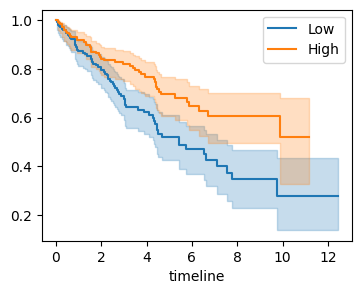

KIRC DSS 0.0021675414954083505


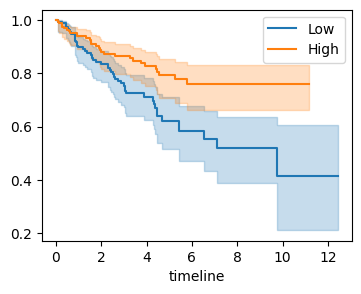

KIRC DFI 0.0483163993933762


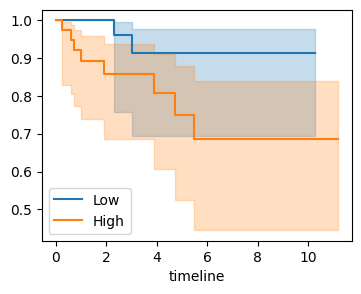

KIRP OS 0.030285990717683006


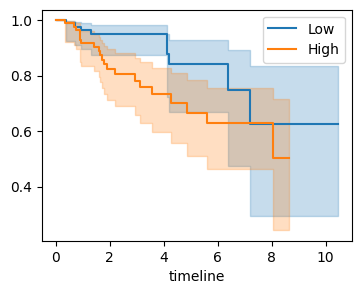

KIRP DSS 0.01139579862849623


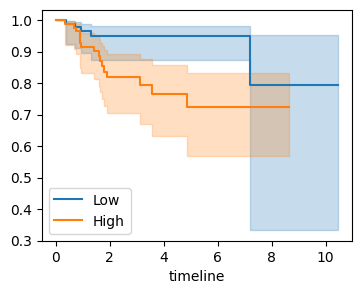

KIRP PFI 0.012506435036998111


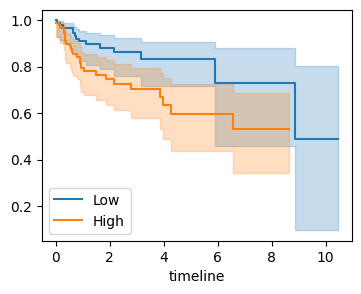

LGG OS 1.6025555989839807e-07


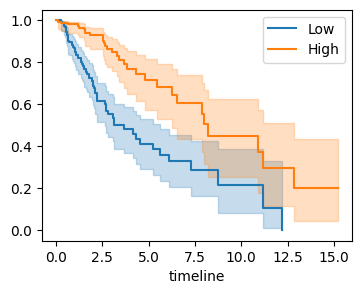

LGG DSS 4.5436822408729503e-07


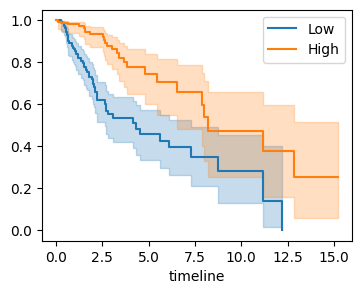

LGG PFI 1.4377503942938299e-06


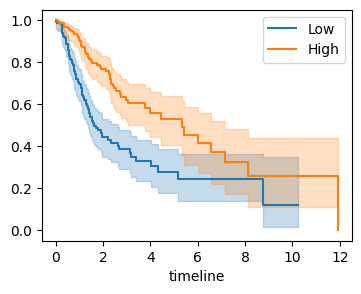

LIHC DSS 0.031543318436973646


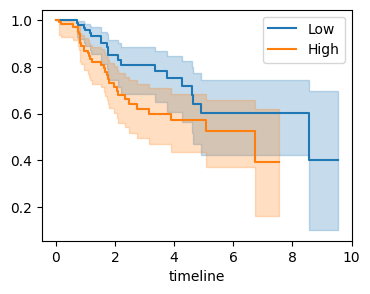

LUAD OS 0.040819742590301945


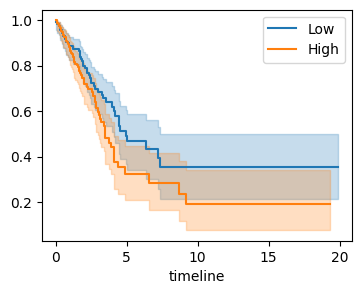

LUAD DSS 0.030643808491873963


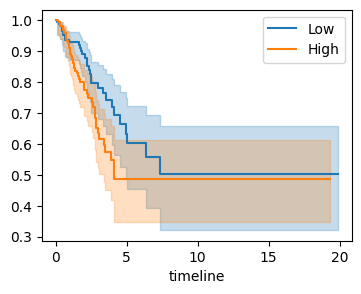

LUSC OS 0.0223956374859234


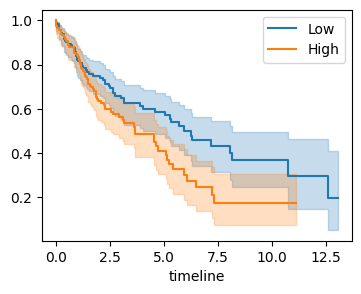

LUSC DSS 0.00028358720743816617


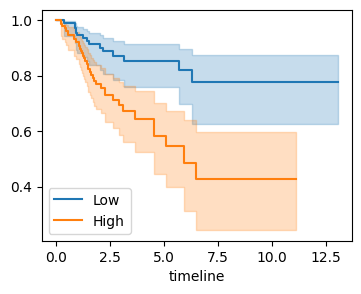

LUSC PFI 0.012159778179587934


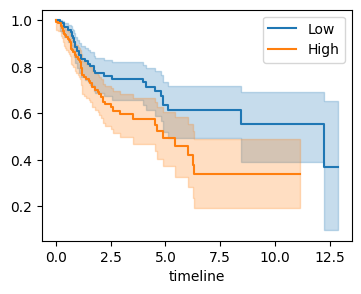

MESO OS 0.0003675865427667954


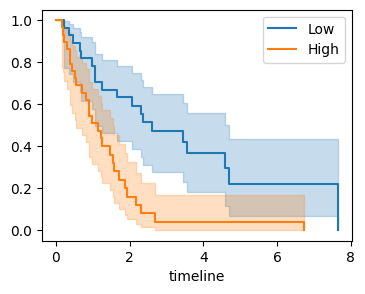

MESO DSS 4.6541305809064765e-06


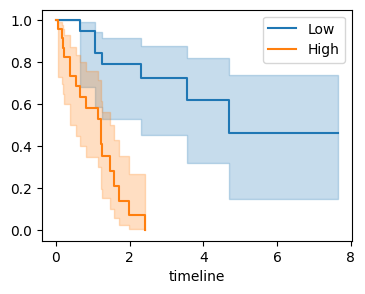

MESO DFI 0.007144792873355235


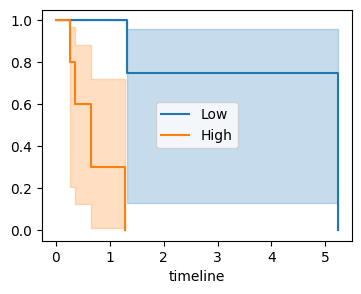

MESO PFI 0.04294789385539251


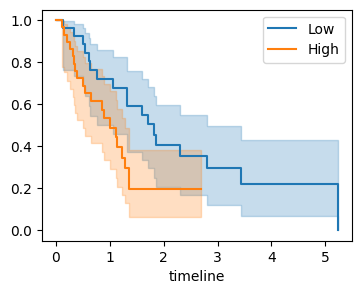

PAAD PFI 0.03623485290425471


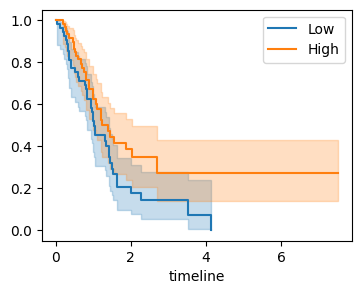

SARC DFI 0.0303092677197763


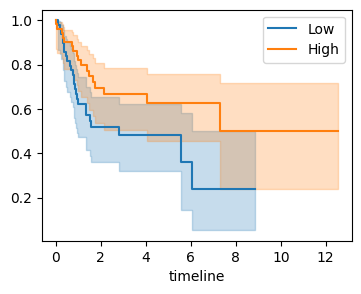

THCA OS 0.03554883417492408


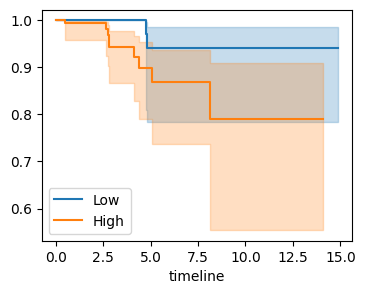

In [5]:
# plot survival by mesenchymization score
cancer_types = (adata.obs['cancer type abbreviation']
                .sort_values().unique().tolist())
survival_types = ('OS', 'DSS', 'DFI', 'PFI')
for cancer_type in cancer_types:
    for survival_type in survival_types:
        out = fit_survival(adata.obs,
                           cancer_type,
                           survival_type,
                           'latent_z',
                           figsize = (4, 3))
        if out and out[1] < .05:
            print(cancer_type, survival_type, out[1])
            plt.show()
        elif out:
            plt.close()

ACC OS 8.679304207098281e-05


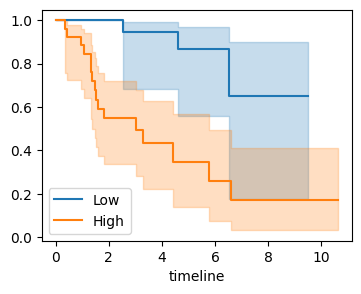

ACC DSS 0.0003803847500490581


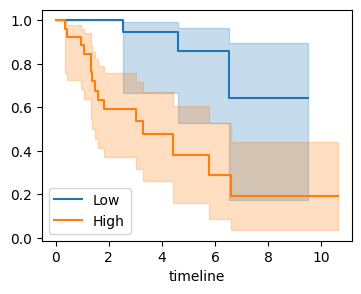

ACC DFI 0.006972485229261441


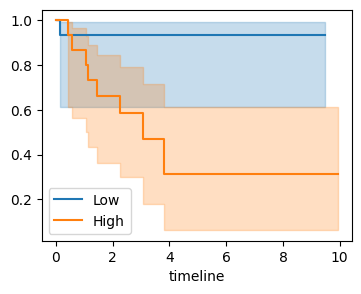

ACC PFI 6.177347391137303e-06


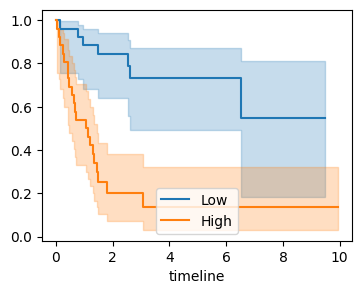

KIRC OS 0.01893804545935194


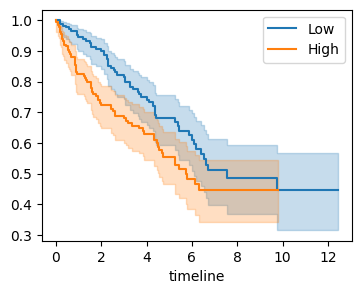

KIRC DSS 0.00651975961193058


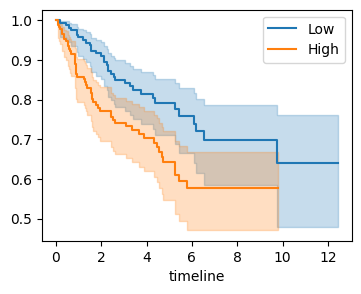

KIRP DSS 0.012411427219308019


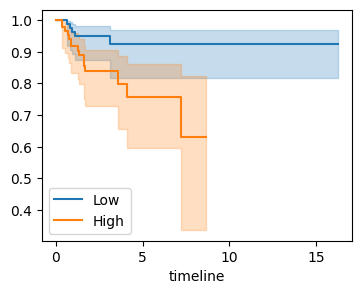

KIRP DFI 0.016294106923734872


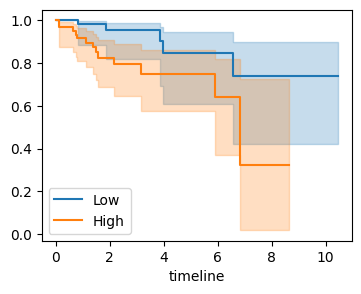

KIRP PFI 0.001390109308753568


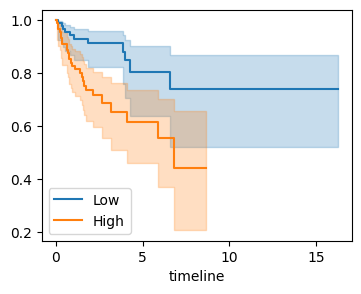

UVM OS 0.007844368114917944


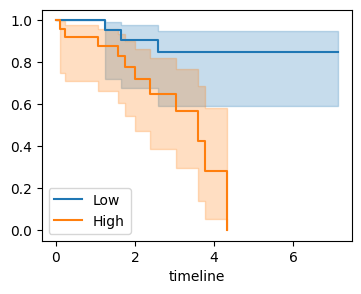

UVM DSS 0.035168125581165936


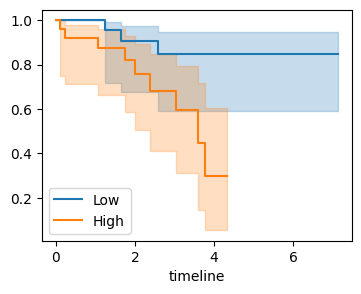

In [6]:
# plot survival by Rps26/20 score
genes, name = ['Rps26', 'Rps20'], 'ribo_score'
for cancer_type in cancer_types:
    msk = (adata.obs['cancer type abbreviation'] == cancer_type)
    _adata_ = adata[msk].copy()
    sc.tl.score_genes(_adata_, genes, ctrl_as_ref = True, score_name = name)
    for survival_type in survival_types:
        out = fit_survival(_adata_.obs,
                           cancer_type,
                           survival_type,
                           name,
                           figsize = (4, 3))
        if out and out[1] < .05:
            print(cancer_type, survival_type, out[1])
            plt.show()
        elif out:
            plt.close()